### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.signal import convolve2d


In [2]:
def readGrid(fileName, size):
    key = {
        "X": 1,
        "O": -1,
        ".": 0
    }

    grid = np.zeros([size, size])
    grid = grid.astype(str)

    with open(fileName) as file:
        y = 0
        for line in file:
            x = 0
            elems = [string.strip() for string in line.split("\t")]
            for elem in elems:
                grid[x,y] = elem
                x += 1
            y += 1
    return grid.T

In [3]:
def schelling(fileName, size, tol, iterations=1000):
    grid = readGrid(fileName, size) # get grid    
    playing = True # while players can move
    history = []
    
    frees, playerCount = findFrees(grid, tol)
    playing = True
    
    for i in range(iterations): 
        if playing:
            temp = np.copy(grid)
            
            grid, neighFrac, frees = schelling_step(grid, tol, frees)
            history.append(neighFrac/playerCount)
            
            if (temp == grid).all():
                playing = False
        else:
            history.append(history[-1])
    
    # check player retention
    emptys = grid=="."
    count = 0
    for elem in emptys.flatten():
        if elem:
            count += 1
    if count != 2500:
        print("lost players")
        return None
        
    return history

In [4]:
def findFrees(grid, tol):
    kernel = np.array([
            [1, 1, 1],
            [1, 0, 1],
            [1, 1, 1]])
    X_neighs = convolve2d(grid == "X", kernel, mode='same') # get X neighbors per cell
    O_neighs = convolve2d(grid == "O", kernel, mode='same') # get O neighbors per cell
    emptys = grid=="."
    
    freeX = set()
    freeO = set()
    playerCount = 0
    
    for x in range(len(grid)):      # loop through grid
        for y in range(len(grid)):
            cord = (x,y)
            if emptys[cord]: # if empty
                if X_neighs[cord] >= tol: # update possible X candidate
                    freeX.add(cord)
                elif O_neighs[cord] >= tol: # update possible O candidate
                    freeO.add(cord)
            else: # else if not empty update player count
                playerCount += 1
                
    return ((freeX, freeO), playerCount)

def schelling_step(grid, tol, frees):
    
    kernel = np.array([
                [1, 1, 1],
                [1, 0, 1],
                [1, 1, 1]])
    X_neighs = convolve2d(grid == "X", kernel, mode='same')
    O_neighs = convolve2d(grid == "O", kernel, mode='same')
    
    neighFrac = 0    
    freeX, freeO = frees
    for x in range(len(grid)):      # loop through grid
        for y in range(len(grid)):
            cord = (x,y)
            symbol = grid[cord]
            
            if symbol == ".": # if empty update free spots
                if X_neighs[cord] >= tol:
                    freeX.add(cord)
                elif O_neighs[cord] >= tol:
                    freeO.add(cord)
                    
            elif symbol == "X": # else if X
                neighFrac += X_neighs[cord]/8 # add neighbor frac / 8 spots
                if X_neighs[cord] < tol: # if not satisfied
                    if len(freeX) > 0: # and if free spots left
                        newPos = freeX.pop() # get next free X spot
                        freeO.discard(newPos) # remove spot if in O free list
                        grid[newPos] = symbol # swap spots
                        grid[cord] = "."

            elif symbol == "O": # else if O
                neighFrac += O_neighs[cord]/8 # add neighbor frac / 8 spots
                if O_neighs[cord] < tol: # if not satisfied
                    if len(freeO) > 0: # and if free spot left
                        newPos = freeO.pop() # get next free spot
                        freeX.discard(newPos) # remove spot if in X free list
                        grid[newPos] = symbol # swap spots
                        grid[cord] = "."
                  
    return ( grid, neighFrac, (freeX, freeO) )

In [23]:
def trend(tols, size, fileName, iterations=20):

    trends = []

    for tol in tols:
        print("tol: ", str(tol))
        toAvarage = []
        for i in range(iterations):
            toAvarage.append(schelling(fileName, size, tol))
        toAvarage = np.asarray(toAvarage)
        trends.append(np.mean(toAvarage, axis=0))
    return trends

def plot(tols, data, ran=None):
    size = len(tols)
    for i in range(size):
        if ran==None:
            plt.plot(data[i], label = "tol of " + str(tols[i]))
        else:
            plt.plot(data[i][:ran], label = "tol of " + str(tols[i]))
    plt.legend()
    plt.show()

In [21]:
tols = [2,3,4,5,6]
size = 150
fileName = "grid.txt"
# res = schelling(fileName, size, tols[1])
data = trend(tols, size, fileName)
print(np.array(data).shape)

tol:  2
tol:  3
tol:  4
tol:  5
tol:  6
(5, 1000)


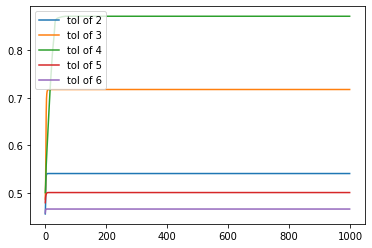

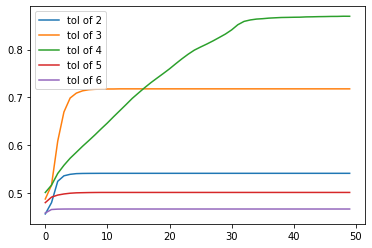

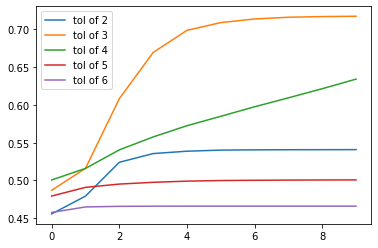

In [24]:
plot(tols, data)
plot(tols, data, 50)
plot(tols, data, 10)
